In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# https://www.newyorkfed.org/microeconomics/databank
# https://www.newyorkfed.org/medialibrary/Interactives/sce/sce/downloads/data/FRBNY-SCE-Survey-Core-Module-Public-Questionnaire.pdf?sc_lang=en
df = pd.read_csv('./data/frbny-sce-public-microdata-latest 2.csv', sep=';')

/var/folders/zr/h_4389yx0t372wtwlt21sddw0000gn/T/ipykernel_92637/1120575821.py:3: DtypeWarning: Columns (209) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/frbny-sce-public-microdata-latest 2.csv', sep=';')


In [3]:
# truncate the distributions to [-12, 12] by removing bin1 and bin10
sdf = df[['date', 'Q9_bin2', 'Q9_bin3', 'Q9_bin4', 'Q9_bin5', 'Q9_bin6',
       'Q9_bin7', 'Q9_bin8', 'Q9_bin9']].copy()

sum = sdf['Q9_bin2'].copy()
for i in range(3, 9):
    sum += sdf[f'Q9_bin{i}']

for i in range(2, 9):
    sdf[f'Q9_bin{i}'] = 100.0 * sdf[f'Q9_bin{i}'] / sum

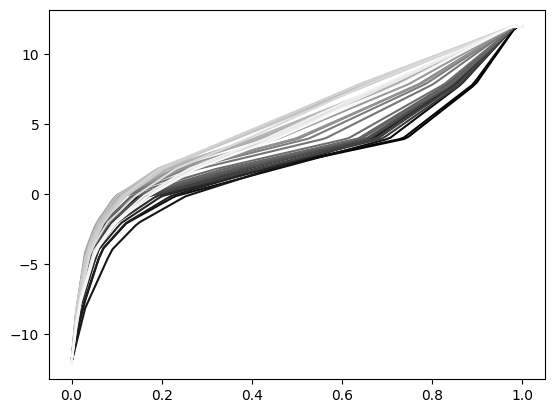

In [4]:
def bins_to_cdf(bins, weights, sup):
    F = np.zeros_like(sup)
    bin_i = 0
    for i in range(1, len(sup)):
        if sup[i] > bins[bin_i+1]:
            bin_i += 1
        n_points_in_bin = ((bins[bin_i] <= sup) & ( sup <= bins[bin_i+1])).sum()
        F[i] = F[i-1] + weights[bin_i] / n_points_in_bin
    return F

def cdf_to_quantiles(q_sup, f_sup, F):
    return np.interp(q_sup, F, f_sup)

def bins_to_q(bins, weights, q_sup):
    sup_size = q_sup.shape[0]
    f_sup = np.linspace(np.min(bins), np.max(bins), sup_size)
    F = bins_to_cdf(bins, weights, f_sup)
    return cdf_to_quantiles(q_sup, f_sup, F)


bins = np.array([ -12, -8, -4, -2, 0, 2, 4, 8, 12 ])

f_sup = np.linspace(-12, 12, 100)
q_sup = np.linspace(0, 1, 100)


# F = bins_to_cdf(bins, h, f_sup)
# Q = cdf_to_quantiles(q_sup, f_sup, F)

# plt.grid(); plt.scatter(f_sup, F, s=1)
# for i in range(len(bins)-1): plt.plot([bins[i], bins[i+1]], [h[i], h[i]], c='black')


def _row_to_cdf(row):
    weights = row.values[1:][::-1]/100
    weights /= weights.sum()
    return bins_to_cdf(bins, weights, f_sup)


def _row_to_q(row):
    weights = row.values[1:][::-1]/100
    weights /= weights.sum()
    return bins_to_q(bins, weights, q_sup)


cdfs = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_cdf, axis=1))]
quantiles = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_q, axis=1))]


for i in range(quantiles.shape[0]):
    plt.plot(q_sup, quantiles[i,:], c=(i/35.0,i/35.0,i/35.0))

# for i in range(quantiles.shape[1]):
#     plt.plot(range(quantiles.shape[0]), quantiles[:,i])

In [6]:
from pyfrechet.metric_spaces import MetricData
import pyfrechet.metric_spaces.wasserstein_1d as W1d
from scipy.optimize import minimize

def geodesic(x, theta, mu):
    return theta * x + (1-theta)*mu

def phi_hat(x, tol=None):
    mu_hat = MetricData(W, x).frechet_mean()
    T = x.shape[0]
    tol = tol or 1.0 / np.sqrt(T)
    def L(phi): return np.array([ W._d(x[j+1,:], geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]

def bootstrap(x, stat, B, boot_fraction):
    bootstrap = np.zeros(B)
    s = int(np.floor(x.shape[0]) * boot_fraction)
    for b in range(B):
        permed = np.random.permutation(x)[:s, :]
        bootstrap[b] = stat(permed)
    return bootstrap

def Dt(x):
    return np.array([ W._d(x[j,:], x[j+1,:])**2 for j in range(x.shape[0]-1) ]).mean()

def predict(mu, phi, x):
    x_hat = np.zeros_like(x)
    x_hat[0,:] = mu
    for t in range(1, x.shape[0]):
        x_hat[t, :] = geodesic(x[t-1, :], phi, mu)
    return x_hat

B = 500
x = quantiles
W = W1d.Wasserstein1D()
mu_hat = MetricData(W, quantiles).frechet_mean()

phi_hat_ = phi_hat(x)
Dt_ = Dt(x)

x_hat = predict(mu_hat, phi_hat_, x)

err_0 = np.array([ W._d(x[t,:], mu_hat)**2 for t in range(1, x.shape[0]) ])
err = np.array([ W._d(x[t,:], x_hat[t,:])**2 for t in range(1, x.shape[0]) ])

booted_phi = bootstrap(x, phi_hat, B, 0.9)
booted_dt = bootstrap(x, Dt, B, 0.9)

INFO: Using numpy backend
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:22: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/python3.9/site-packages/fdasrsf/umap_metric.py:54: NumbaDeprecationWarning:The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 /Users/matthieubulte/.pyenv/versions/3.9.16/lib/pyt

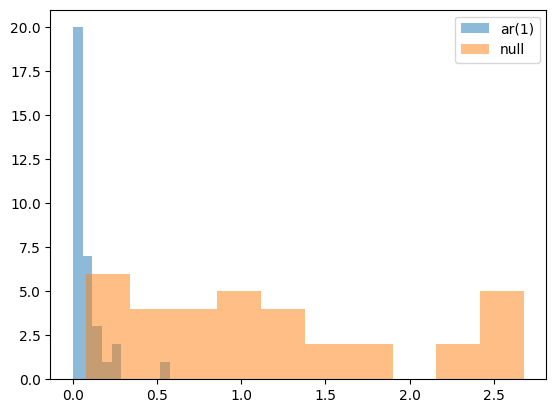

In [7]:
plt.hist(err, alpha=.5, label='ar(1)')
plt.hist(err_0, alpha=.5, label='null')
plt.legend()

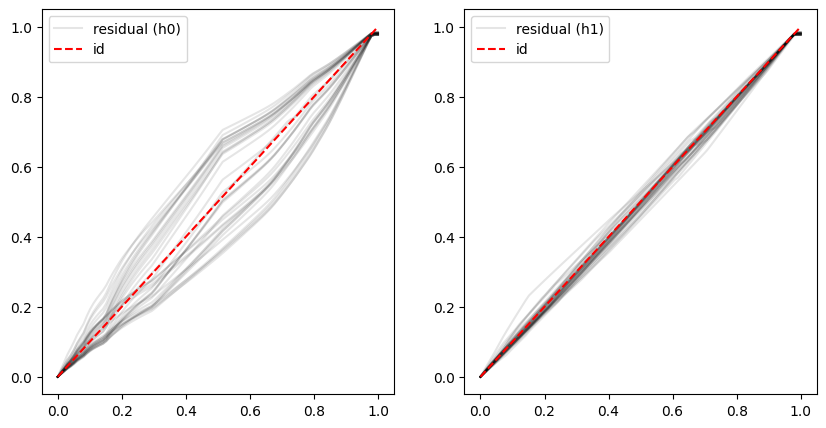

In [91]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,2)

res = np.interp(x_hat[1,:], f_sup, cdfs[1,:])
plt.plot(q_sup, res, color='black', alpha=0.1, label='residual (h1)')

for i in range(2,quantiles.shape[0]):
    res = np.interp(x_hat[i,:], f_sup, cdfs[i,:])
    plt.plot(q_sup, res, color='black', alpha=0.1)

plt.plot(q_sup, q_sup, color='red', linestyle='--', label='id')
plt.legend()

plt.subplot(1,2,1)

res = np.interp(x_hat[1,:], f_sup, cdfs[1,:])
plt.plot(q_sup, res, color='black', alpha=0.1, label='residual (h0)')

for i in range(2,quantiles.shape[0]):
    res = np.interp(mu_hat, f_sup, cdfs[i,:])
    plt.plot(q_sup, res, color='black', alpha=0.1)

plt.plot(q_sup, q_sup, color='red', linestyle='--', label='id')
plt.legend()


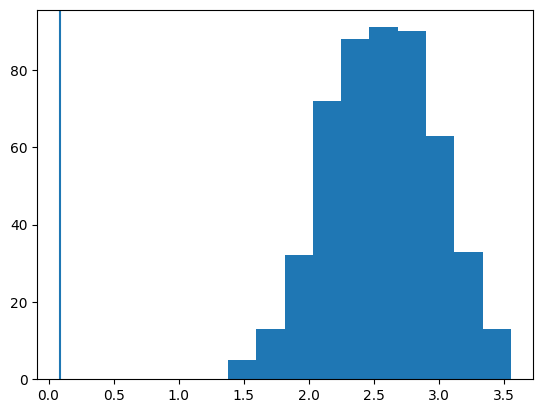

In [58]:
plt.hist(booted_dt)
plt.axvline(Dt_)

0.9453198508842389

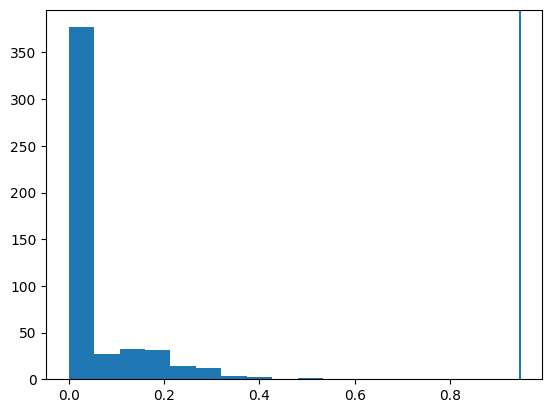

In [9]:
plt.hist(booted_phi)
plt.axvline(phi_hat_)
phi_hat_

35

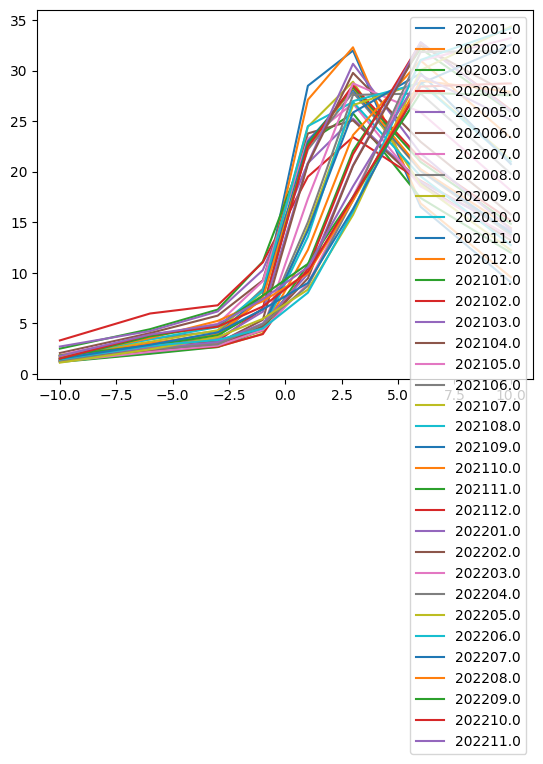

In [6]:
# [inf, 12] [12, 8] [8, 4] [4, 2] [2 0] [0, -2] [-2, -4], [-4, -8], [-8, -12], [-12, -inf]

# the rate of inflation will be 12% or higher (bin 1) _______ percent chance
# the rate of inflation will be between 8% and 12% (bin 2) _______ percent chance
# the rate of inflation will be between 4% and 8% (bin 3) _______ percent chance
# the rate of inflation will be between 2% and 4% (bin 4) _______ percent chance
# the rate of inflation will be between 0% and 2% (bin 5) _______ percent chance
# the rate of deflation (opposite of inflation) will be between 0% and 2% (bin 6)
# the rate of deflation (opposite of inflation) will be between 2% and 4% (bin 7) _______ percent chance
# the rate of deflation (opposite of inflation) will be between 4% and 8% (bin 8) _______ percent chance
# the rate of deflation (opposite of inflation) will be between 8% and 12% (bin 9) _______ percent chance
# the rate of deflation (opposite of inflation) will be 12% or higher (bin 10) _______ percent chance

bins = np.array([ 10, 6, 3, 1, -1, -3, -6, -10 ])
# plt.plot(
#     bins,
#     sdf[sdf['date'] == 202001].mean()[2:]
# )

_df = sdf.groupby('date').mean().reset_index()
for i in range(len(_df)):
   plt.plot(
        bins,
        _df.iloc[i].values[1:],
        label=_df.iloc[i].date
    ) 
plt.legend()
len(_df)